In [1]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.mode.chained_assignment = None

# Applied Machine Learning
In this assignment we will explore a dataset about soccer players and referees, focusing predictions and clustering essentially on the players' skin color.

## Preprocessing

Let's have a look at the data:

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.ix[:5,:14]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0


In [3]:
data.ix[:5,14:]

,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


### NaN values

In [4]:
data.isnull().sum()

playerShort          0
player               0
club                 0
leagueCountry        0
birthday             0
height             263
weight            2243
position         17726
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          21407
rater1           21407
rater2           21407
refNum               0
refCountry           0
Alpha_3              1
meanIAT            163
nIAT               163
seIAT              163
meanExp            163
nExp               163
seExp              163
dtype: int64

In [5]:
filtered = data.dropna()

In [6]:
len(filtered)/len(data)

0.790649738406333

If we would decide to simply discard all the NaN values, we would keep only 21% of the DataSet. We are mainly interested in the skin color of each player so we will have a closer look at the `rater1` and `rater2` skin rating columns.

### Skin Color

In [7]:
len(data[data.rater1.isnull() & (data.rater2.isnull())])/len(data)

0.14659517352836443

15% of the dataset will be discarded as it doesn't give any information about the skin color.

In [8]:
skin_data = data.dropna(how='all', subset=['rater1','rater2'])

We will also drop the cell with missing IAT or Exp score as there are only 152

In [9]:
skin_data = skin_data.dropna(how='all', subset=['meanIAT', 'nIAT'])

In [10]:
len(skin_data[skin_data.rater1.isnull() | (skin_data.rater2.isnull())])

0

We can observe that there were always values for both `rater1` and `rater2` or not any values. Let's have a look at the data for which the raters gave a different skin color.

In [11]:
skin_data_differ = skin_data[skin_data.rater1 != skin_data.rater2]

In [12]:
len(skin_data_differ)/len(skin_data)

0.23189896198219623

For 23% of the player the two raters gave a different value. Let's see if they gave skin colors that are almost the same or opposite skin colors:

In [13]:
skin_data['skin_difference'] = skin_data.apply(lambda x: abs(x['rater1'] - x['rater2']), axis=1)

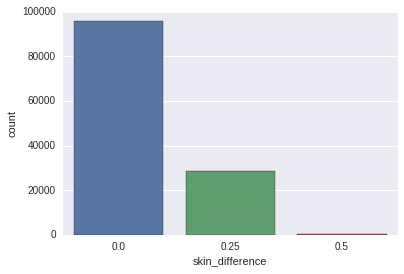

In [14]:
palette = sns.color_palette()
sns.countplot(x="skin_difference", data=skin_data);

If the two raters differ, it is only by one on the 5-point scale or by 2. We decide to keep the average value of the two raters on a 0 to 8 scale. (so that the average keep all the information)

In [15]:
skin_data['skin'] = skin_data.apply(lambda x: (x['rater1']+x['rater2'])/2*4, axis=1)

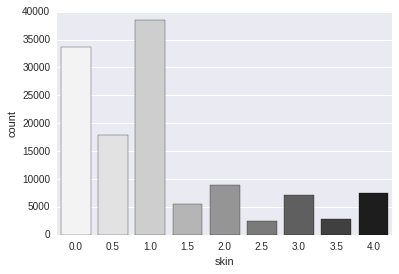

In [16]:
sns.countplot(x="skin", data=skin_data, palette=sns.color_palette("Greys", 9));

Since we are looking at data from countries with predominantly caucasion populations, it seems reasonable to have a larger white population.

### Age
There are not any missing birthday value. We will have a look at the age distribution.

In [17]:
# The birthday string is converted into a datetime type
import datetime
skin_data['birthday'] = skin_data.apply(lambda x: datetime.datetime.strptime(x['birthday'], "%d.%m.%Y"), axis=1)

In [18]:
skin_data['birthday'].head()

0   1983-08-31
1   1982-01-08
5   1979-11-08
6   1985-11-10
7   1986-04-04
Name: birthday, dtype: datetime64[ns]

In [19]:
import datetime as DT
now = pd.Timestamp(DT.datetime.now())
# We will plot the age in year of the players from their birthday
age = skin_data[['birthday']]
skin_data['age'] = age.apply(lambda x: int((now - x['birthday']).days/365.25) , axis=1)

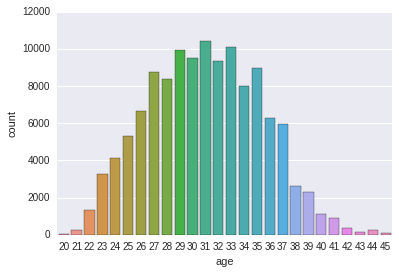

In [20]:
p = sns.countplot(x="age", data=skin_data)

Everything seems fine for the date values. Note that this is the distribution for the data non-aggregated by player. So it is reasonable to assume that older players, who have many more interactions with referees, appear many more times in this countplot than younger players, which is why the mean is surprisingly high.

### League Country

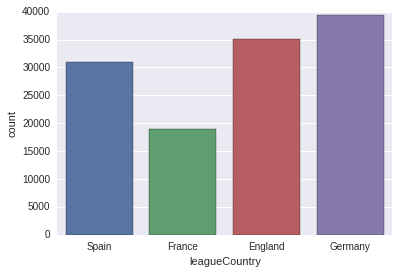

In [21]:
sns.countplot(x="leagueCountry", data=skin_data);

### Height

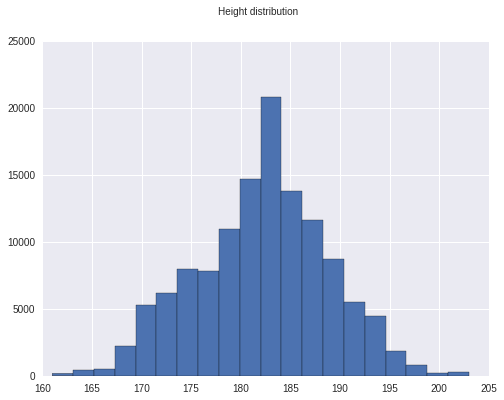

In [22]:
import matplotlib.ticker as ticker
f, ax = plt.subplots(figsize=(8,6))
heights = skin_data['height'].dropna()
plt.hist(heights, bins=20);
f.suptitle("Height distribution");

There is no outliers and the distribution looks normal.

### Weight

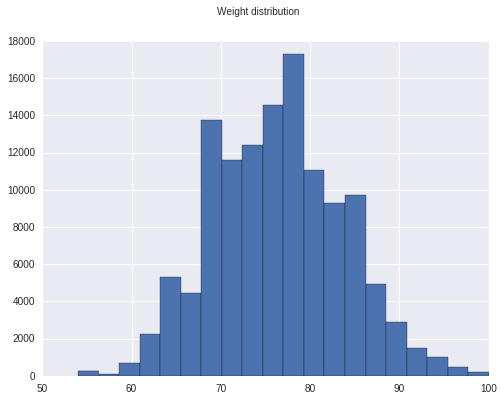

In [23]:
f, ax = plt.subplots(figsize=(8, 6))
plt.hist(skin_data.weight.dropna(), bins=20)
f.suptitle("Weight distribution");

### Position 

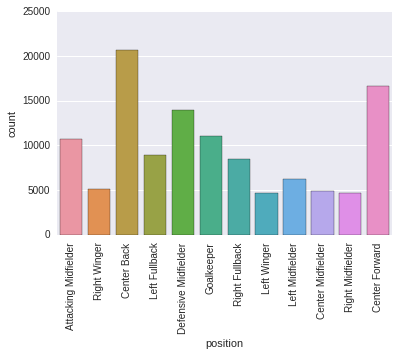

In [24]:
pos = sns.countplot(x="position", data=skin_data);
plt.setp(pos.get_xticklabels(), rotation=90);

In [25]:
missing_values = skin_data['position'].isnull().value_counts()

In [26]:
missing_values[1]/missing_values[0]

0.072870515627424276

7% of the positions are missing. We will replace them by the most by a category `Missing Position`.

### Referees

In [27]:
print('There are ' + str(len(skin_data['refNum'].value_counts())) + ' different referees.')

There are 2967 different referees.


In [28]:
print('Which come from ' + str(len(skin_data['refCountry'].value_counts())) + ' different countries...')

Which come from 155 different countries...


### Standardization, Categorical Features Encoding and Replacing Missing Values

We transform each feature into a representation that is more suitable for the machine learning methods. Each feature will be **standardized** if it is a float number (remove mean value, scale dividing by standard deviation) using the `StandardScaler()` function from `sklearn`. If there are missing values, they will be replaced by the mean, which is 0 after applying the StandardScaler. The categorical features will be **encoded** using the `LabelEncoder()` function which converts categorical variable into numerical values. The learning models consider continuous values and don't handle categorical features, but we hope RandomForest will be robust again those values. The missing categorical variables are replaced by `Missing Category`. We discard the name of the player, as well as the photoID and the birthday as it is a one to one relationship with the skin color.

In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, Imputer 
from sklearn.feature_extraction import DictVectorizer

# Replacing missing values for categorical data:
skin_data['position'] = skin_data['position'].fillna('Missing Position')
# For the Alpha_3 there is only one missing value so we will drop it
skin_data = skin_data.dropna(subset=['Alpha_3'])

# Features to be standardized
stand = ['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'redCards', 
         'yellowReds', 'age', 'skin', 'skin_difference', 'rater1', 'rater2']
# Categorical features to be encoded
cat = ['club', 'leagueCountry', 'position']

standardized = skin_data.copy()
standardized['skin_nonorm'] = standardized['skin']
# Encode categories
for c in cat:
    standardized[c] = LabelEncoder().fit_transform(standardized[c])

# The first function fills the missing values and the second one will apply the standardization 
for s in stand:
    standardized[s] = Imputer(strategy='mean', axis=1).fit_transform(standardized[s])[0]
    standardized[s] = StandardScaler().fit_transform(standardized[s])
    
     
# Discard names of players and photoID
skin_data_dropped = standardized.drop(labels=['playerShort', 'player', 'photoID', 'birthday', 'Alpha_3'], axis=1)

In [30]:
skin_data_dropped.head()

,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_difference,skin,age,skin_nonorm
0,70,3,-0.753585,-0.609844,0,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,0.326391,712.0,0.000564,0.396000,750.0,0.002696,1.800031,0.317661,0.459019,1.5
1,51,1,-0.459621,0.785575,12,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,-0.547478,1.617787,0.687089,3.0
5,34,0,-0.018675,-0.749386,1,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.800031,-0.549090,1.371299,0.5
6,48,0,0.716234,0.506492,6,-0.557169,-0.182707,-0.625217,-0.658021,-0.374371,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.800031,-0.549090,0.002879,0.5
7,54,0,-0.312639,-1.168011,4,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,-0.547478,2.484538,-0.225191,4.0


# 1. Random Forest Skin Color Regressor

**We use Random Forest Regressor and Classifier because darkness of skin reflect a continuous value, we talked about it with Catasta on slack**

The most important parameters that can affect the accuracy of the random forest regressor are the number of trees in the forest `n_estimators`, the number of features to consider when looking for a best split `max_features`, the maximum depth of the tree `max_depth` and the minimum number of samples required to be at a leaf node `min_samples_leaf`. There are other parameters but we will have a closer look at those ones.

We seperate the data between the features used for prediction and the target features (skin). We need to drop the `rater1`, `rater2`, `skin` and `skin_difference` values as we want to predict the `skin`.

In [31]:
to_predict = ['rater1', 'rater2', 'skin', 'skin_difference', 'skin_nonorm']
data = skin_data_dropped.drop(labels=to_predict, axis=1)
features = data.columns
# Skin to predict
# skin_nonorm is transformed to integer values, which is useful for later tasks
target = skin_data_dropped.skin_nonorm.apply(lambda x: x*2).values.ravel() 


First, all the columns will be used to train the Random Forest Classifier.

### n_estimators
We will test the accuracy of the model for different number of trees. We use 5-folds cross validation to measure the accuracy of the predictive model, we use the mean of the accuracy over the 5 folds to tune the parameters.

In [32]:
from sklearn.metrics import accuracy_score
from sklearn import model_selection

In [33]:
number_trees = [5,10,20,50,100,200]
accuracy = []

for t in number_trees:
    tree = RandomForestRegressor(n_estimators=t)
    scores = model_selection.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

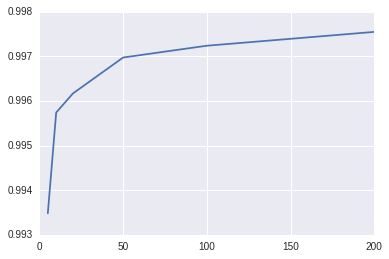

In [34]:
plt.plot(number_trees, accuracy);

Higher number of trees will avoid overfitting (because the model takes the maximum voting of predictions) and give more stable predictions but it takes the model longer to fit the data.

However, notice that this accuracy is impossibly high, which makes sense when we consider that each player appears multiple times in the dataset, due to their presence in multiple dyads. So players will be recognised due to their almost unique personal characteristics (e.g. height, weight, age, position, club). 

### Rethinking the data - aggregation

In order to get more reasonable results and train our model to recognise unseen players, we group on each player and aggregate the information.

We can add some other features on top of the aggregated means of these columns

In [35]:
# Weighted means of the meanIAT and meanExp measures
standardized['weightMeanIAT'] = standardized.meanIAT * standardized.nIAT / standardized.nIAT.sum()
standardized['weightMeanExp'] = standardized.meanExp * standardized.nExp / standardized.nExp.sum()
unique_count = lambda df: len(df.unique())
agg_stderr = lambda df: math.sqrt(np.mean(df**2))

In [36]:
f = {'skin': 'mean', 'skin_difference': 'mean', 'skin_nonorm': 'mean', 'meanIAT': 'mean', 'meanExp': 'mean', 
     'weight': 'mean', 'height': 'mean', 'age': 'mean', 'games': 'mean', 'victories': 'mean', 'ties': 'mean', 
     'defeats': 'mean', 'goals': 'mean', 'yellowCards': 'mean', 'yellowReds': 'mean', 'redCards': 'mean', 
     'refNum': unique_count, 'refCountry': unique_count, 'seIAT': agg_stderr, 'seExp': agg_stderr, 
     'weightMeanIAT': 'mean', 'weightMeanExp': 'mean', 'position': 'mean'}

In [37]:
grouped = standardized.groupby('playerShort').agg(f)

Let's split the data into the feature set and the target data.

We convert here the skin values to integers in $[0..8]$, so if we compare it with a classifier, we have a total of 9 classes.

In [38]:
to_predict = ['skin', 'skin_difference', 'skin_nonorm']
# Skin to predict
target = grouped.skin_nonorm.apply(lambda x: x*2).values.ravel() 

# Features
data = grouped.drop(labels=to_predict, axis=1)
features = data.columns


### Feature correlation matrix

Before looking into training and tuning the model, it is interesting to look at the relations between features. To this end, we plotted a feature-correlation matrix.

In [39]:
def correlation_matrix(df, title):
    """Plot the pairwise correlations in df"""
    sns.set(style="white")
    corr = df.corr(method='pearson')
 
    # Generate a mask for the upper triangle 
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
 
    # Set up the matplotlib figure 
    f, ax = plt.subplots(figsize=(11, 9))
 
    # Generate a custom diverging colormap 
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
    # Draw the heatmap with the mask and correct aspect ratio 
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, square=True,
                linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)
 
    # Rename the labels (movement_activity_i -> mi, stationarity_i -> si) 
    curr_labels = [item.get_text() for item in ax.get_xticklabels()]
    split_labels = [str.split(label, '_') for label in curr_labels]
    labels = [lst[0][0]+lst[-1] for lst in split_labels] # shortening the name 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(reversed(labels))
 
    # Set title 
    f.suptitle(title, fontsize=18)

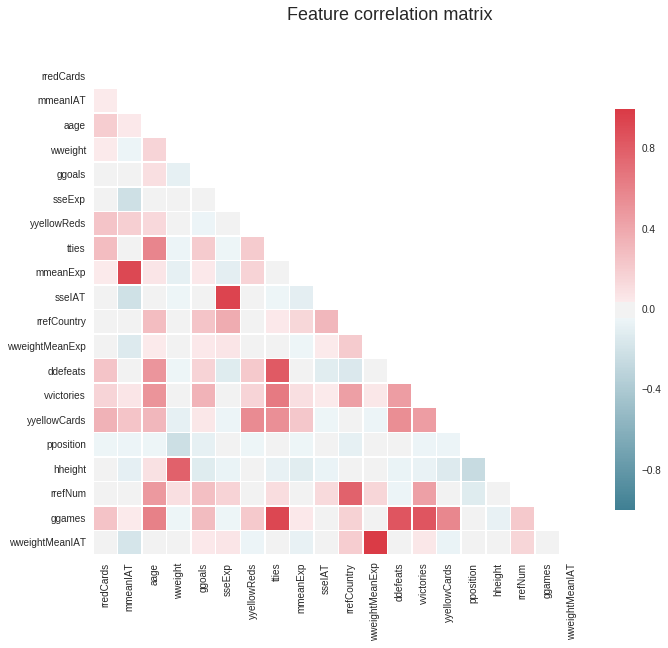

In [40]:
correlation_matrix(data, "Feature correlation matrix")

Some of the features show an obvious correlation with others (e.g. `games` has a strong positive correlation with `ties`, `victories`, `defeats`). Other than these obvious connections, the correlation matrix doesn't show any surprising correlations.

### `n_estimators` with aggregated data

With the grouping on players and aggregation of the features done, let's recompute the score with varying `n_estimators` parameter for our `RandomForestRegressor`.

In [41]:
number_trees = [1,5,10,20,50,100,200]
score = []

for t in number_trees:
    tree = RandomForestRegressor(n_estimators=t)
    scores = model_selection.cross_val_score(tree, data, target, cv=5)
    score.append(scores.mean())

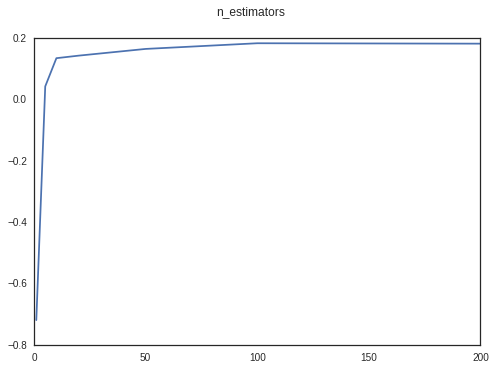

In [42]:
plt.plot(number_trees, score)
plt.suptitle("n_estimators");

The negative score can seem alarming at first, but `RandomForestRegressor`'s `score` function computes the score differently than that of a `RandomForestClassifier`, as is explained in the [doc](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.score). It uses the $R^2$ regression score function (aka coefficient of determination). 

The negative score values indicate that there is a constant model that performs better than ours, with low values of `n_estimators`, which is understandable given the distribution of our data (many more white players than not).

From the progression of the accuracy here, we can see that a good value for `n_estimators` is 100.

### Random Forest accuracy
In order to better understand the performance of our Regressor, we can convert the output so that it corresponds to that of a classifier.

In [43]:
def predict_class_from_reg(model, X, y, test):
    """Returns the predictions of a RandomForestRegressor rounded so as to have classes as output."""
    model.fit(X, y)
    predictions = model.predict(test)
    return np.around(predictions)

In [44]:
def rf_accuracy(model, data, target):
    """Returns the accuracy of a model over a split.
    Rounds the predictions to the """
    x_train, x_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.1, random_state=42)
    rounded_pred = predict_class_from_reg(model, x_train, y_train, x_test)
    return np.sum(np.equal(rounded_pred, y_test)) / float(len(y_test))

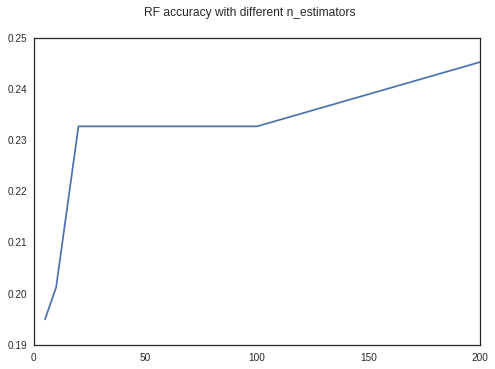

In [47]:
number_trees = [5,10,20,50,100,200]
accuracy = []

for t in number_trees:
    tree = RandomForestRegressor(n_estimators=t)
    accuracy.append(rf_accuracy(tree, data, target))

plt.plot(number_trees, accuracy)
plt.suptitle("RF accuracy with different n_estimators");

*Note* that this is the result of only one train-test split, so not a viable judge for determining stable and efficient parameters. This is noticeable by running the cell above several times, and we see the shape of the curve change quite a lot. The result of the actual score plotted previously is far more reliable.

### max_features
As default, the number of features to consider when looking for the best split is equal to the square root of the number of features. We will test it with different values between 1 and the number of features.

In [48]:
max_features = range(1,len(features)+1)
score = []

for m in max_features:
    tree = RandomForestRegressor(n_estimators=100, max_features=m)
    scores = model_selection.cross_val_score(tree, data, target, cv=10)
    score.append(scores.mean())

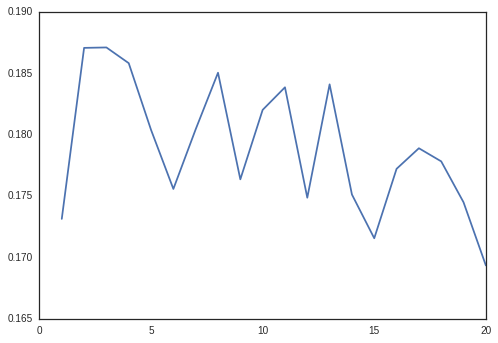

In [49]:
plt.plot(max_features, score);

An good and stable choice for max_features seems to be 5.


### max_depth
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure. We compute the score for several depths, including the default value (indicated by `None`).

In [50]:
# None included to compute 
max_depths = [1,5,10,20,50,75]
accuracy = []

for d in max_depths:
    tree = RandomForestRegressor(n_estimators=100, max_features=5, max_depth=d)
    scores = model_selection.cross_val_score(tree, data, target, cv=10)
    accuracy.append(scores.mean())

In [51]:
tree = RandomForestRegressor(n_estimators=100, max_features=5, max_depth=None)
scores = model_selection.cross_val_score(tree, data, target, cv=10)
accuracy.append(scores.mean())

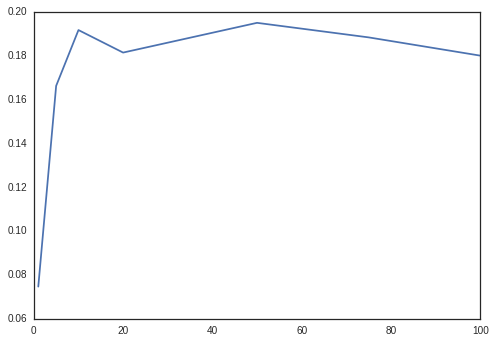

In [52]:
max_depths.append(100) # 100 represents the default value
plt.plot(max_depths, accuracy);

In our case, there is no overfitting problem with a tree having pure nodes. We will keep the default value.

In [53]:
rf_accuracy(RandomForestRegressor(n_estimators=100, max_features=5, max_depth=None), data, target)

0.28930817610062892

### min_samples_leaf
The minimum number of samples required to be at a leaf node.

In [58]:
min_samples = [1,2,3,4,5,10,20]
accuracy = []

for s in min_samples:
    tree = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=s)
    scores = model_selection.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

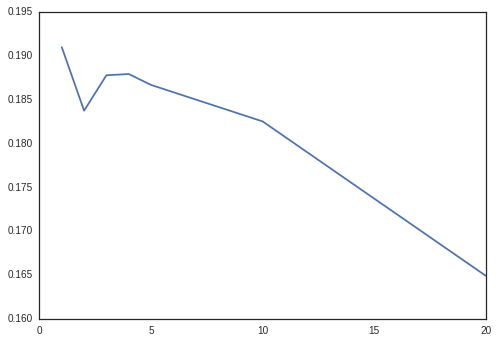

In [59]:
plt.plot(min_samples, accuracy);

If less than 3 samples are in a leaf the model is overfitting and if more than 3 are in a leaf node it is underfitting.

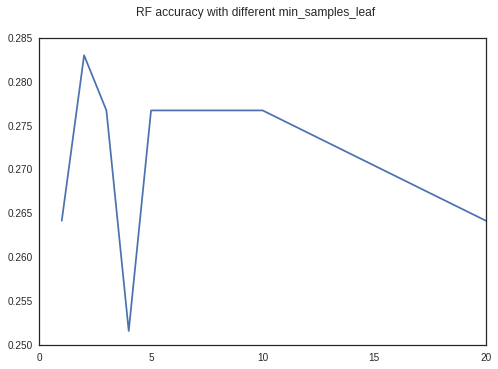

In [56]:
accuracy = []

for t in min_samples:
    tree = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=s)
    accuracy.append(rf_accuracy(tree, data, target))

plt.plot(min_samples, accuracy)
plt.suptitle("RF accuracy with different min_samples_leaf");

### Feature importance of the trained model

Now we will have a look at the features sorted by their score in the tree with the tuned parameter we found.

In [57]:
def features_importance_rf(X, y, rf, print_=True, plot=True):
    """Print and plot the top features importances in X using the rf classifier.
    Returns columns names in order of increasing importance"""
    rf.fit(X, y)
 
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
 
    cols = X.columns
    ord_cols = []
    # Print the feature ranking 
    if print_:
        print("Feature ranking:")
 
        for f in range(X.shape[1]):
            print("%d. feature n° %d %s (%f)" % (f + 1, indices[f], cols[indices[f]], importances[indices[f]]))
            ord_cols.append(cols[indices[f]])
    else:
        for f in range(X.shape[1]):
            ord_cols.append(cols[indices[f]])  
 
    # Plot the feature importance 
    if plot:
        plt.subplots(figsize=(8,6))
        plt.suptitle("Feature importance", fontsize=18)
        plt.bar(range(X.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")
        plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
        
    # Compute accuracy
    print("Accuracy:", rf_accuracy(rf, X, y))
 
    return ord_cols

The red bars in the plot represent the feature importance of the trees and the blue lines are the inter-tree variability.

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=3)
out = features_importance_rf(data, target, rf)

The four highest ranked features are the aggregated standard errors and mean scores of the explicit and implicit racism tests. We can also see that these four features have the highest inter-tree variability. 

Let's see what happens if we remove these top four features.

In [ ]:
reduced_data = data.drop(out[:4], axis=1)
rf_red = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=3)
red_out = features_importance_rf(reduced_data, target, rf_red)

So by removing the features with highest importance, we get an accuracy of about $16\%$ instead of $26\%$. Even though the importance measures (red bars) increased slightly, the order of the feature importances measured seem quite stable.

### Confusion Matrix

With the help of a confusion matrix, we can look at the way our 'classifier' (rounded regressor predictions) labels the OOB objects it receives.

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    np.set_printoptions(precision=2)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Our model with best parameters according to our previous tests
rf = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=3)
# Data split 
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.2)
predictions = predict_class_from_reg(rf, x_train, y_train, x_test)
cm = confusion_matrix(y_test, predictions)
classes = np.unique(y_test)
plot_confusion_matrix(cm, classes)

Our model performs best at predicting players with skin-tone $2.0$ (average rater score of $0.25$ on the original scale). It is also noticeably worse at classifying dark-skinned players than light-skinned ones, which is understandable given the skewed nature of our data (i.e. many more white players present in the set).

# 2. Clustering

We group the referee informations by player and only keep the columns that are relevant, the order is useful because it will be the one used when iteratively removing features

In [136]:
grouped.head()

,skin,skin_difference,meanIAT,meanExp,weight,height,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,skin_nonorm
playerShort,,,,,,,,,,,,,,,
aaron-hughes,-0.549090,1.800031,0.346459,0.494575,-0.749386,-0.018675,0.263530,0.076741,0.317084,0.306836,-0.316979,-0.346780,-0.108671,-0.112016,0.5
aaron-hunt,-0.549090,1.800031,0.348818,0.449220,-0.470302,0.128306,0.111152,0.042866,0.019149,0.207666,0.288572,0.030080,-0.108671,-0.023386,0.5
aaron-lennon,-0.115715,-0.547478,0.345893,0.491482,-1.865721,-2.517367,0.302460,0.338473,0.214040,0.141837,-0.049463,-0.353528,-0.108671,-0.112016,1.0
aaron-ramsey,-0.982466,-0.547478,0.346821,0.514693,-0.051676,-0.606603,-0.138411,0.052472,-0.272310,-0.198705,0.022593,-0.123403,-0.108671,-0.027647,0.0
abdelhamid-el-kaoutari,-0.115715,-0.547478,0.331600,0.335587,-0.470302,-0.312639,0.099263,-0.125225,0.319503,0.158379,-0.345761,-0.222989,0.864236,0.362271,1.0


In [137]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

We now compute the silhouette score and remove iteratively features. We keep track of 2 score, the one by silhouette score of the clusterisation by k-mean and its own labels, and the one corresponding to the proportion of partitionned data along the skin value (split at skin value = 2.0)

In [138]:
skin_labels = (grouped['skin_nonorm'] < 2.0).astype(int) 
skin_labels.head()

playerShort
aaron-hughes              1
aaron-hunt                1
aaron-lennon              1
aaron-ramsey              1
abdelhamid-el-kaoutari    1
Name: skin_nonorm, dtype: int64

In [150]:
def cluster(X):
    kmeans_model = KMeans(n_clusters=2, random_state=1).fit(X)
    labels = kmeans_model.labels_
    
    silhouette_unsupervised = silhouette_score(X, labels)
    np.mean(silhouette_unsupervised)
    eq = skin_labels == labels
    mean = np.mean(eq)
    skin_partition = max(mean, 1-mean)
    
    return  silhouette_unsupervised, skin_partition

We do two iterative feature removing. One with the skin features included and one without. The aim is to find if we can cluster the skin information without having it as a feature.

In [168]:
silhouettes_unsupervised = []
skin_partitions = []
feature_number = []

#We always drop skin_nonorm. It was only used for labeling before standardization
for i in range(len(filtered_col)-1, 5, -1):
    columns = filtered_col[5:i]
    silhouette_unsupervised, skin_partitionning = cluster(grouped[columns])
    
    silhouettes_unsupervised.append(silhouette_unsupervised)
    skin_partitions.append(skin_partitionning )
    print(silhouette_unsupervised, skin_partitionning, columns)
    feature_number.append(i-1)

0.347652515645 0.509779179811 ['weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']
0.350943096869 0.509779179811 ['weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds']
0.354696417852 0.509779179811 ['weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards']
0.371015245425 0.509148264984 ['weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals']
0.394023015198 0.511041009464 ['weight', 'height', 'games', 'victories', 'ties', 'defeats']
0.409970101111 0.51167192429 ['weight', 'height', 'games', 'victories', 'ties']
0.425129269071 0.51167192429 ['weight', 'height', 'games', 'victories']
0.443469374991 0.51167192429 ['weight', 'height', 'games']
0.475079984684 0.51167192429 ['weight', 'height']
0.55352283463 0.502208201893 ['weight']


In [169]:
print(silhouettes_unsupervised)
print(skin_partitions)

[0.3476525156453048, 0.35094309686938324, 0.35469641785175876, 0.37101524542498959, 0.39402301519815797, 0.40997010111071602, 0.42512926907133169, 0.44346937499130695, 0.47507998468394014, 0.55352283462984642]
[0.50977917981072551, 0.50977917981072551, 0.50977917981072551, 0.50914826498422716, 0.51104100946372233, 0.51167192429022079, 0.51167192429022079, 0.51167192429022079, 0.51167192429022079, 0.50220820189274451]


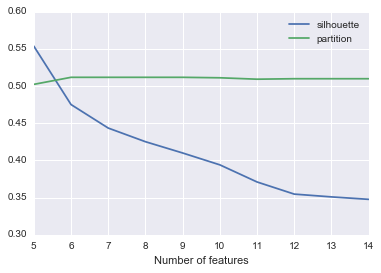

In [170]:
plt.plot(feature_number, silhouettes_unsupervised, label='silhouette');
plt.plot(feature_number, skin_partitions, label='partition');
plt.xlabel('Number of features');
plt.legend();

We can see that the silhouette goes up as the number of features go down (easier to cluster) but it doesn't improve the paritition along skin color. Clusterisation doesn't reveal any correlation with Skin color. 


Let's now try by adding the skin feature to check if there is now a distinction

In [171]:
silhouettes_unsupervised = []
skin_partitions = []
feature_number = []

for i in range(len(filtered_col)-1, 1, -1):
    columns = filtered_col[1:i]
    silhouette_unsupervised, skin_partitionning = cluster(grouped[columns])
    
    silhouettes_unsupervised.append(silhouette_unsupervised)
    skin_partitions.append(skin_partitionning )
    print(silhouette_unsupervised, skin_partitionning, columns)
    feature_number.append(i-1)

0.220936710261 0.558359621451 ['skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']
0.222183058978 0.556466876972 ['skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds']
0.223634526471 0.556466876972 ['skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards']
0.229909739671 0.557728706625 ['skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals']
0.238405175875 0.554574132492 ['skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties', 'defeats']
0.244138560099 0.553943217666 ['skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties']
0.249305642858 0.552681388013 ['skin', 'skin

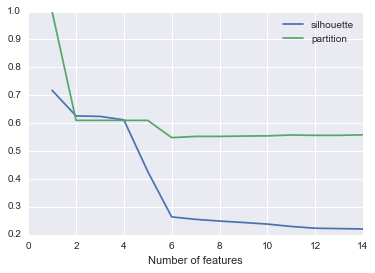

In [172]:
plt.plot(feature_number, silhouettes_unsupervised, label='silhouette');
plt.plot(feature_number, skin_partitions, label='partition');
plt.xlabel('Number of features');
plt.legend();

We can that the silhouette go down and of that the partitionning along skin improve with skin feature (not so surprising) but more surprisingly with skin_difference too.